In [1]:
import torch
import numpy as np
import mne
from torch import nn

In [2]:
from eegcpc.helper import fetch_data

In [3]:
from mne.time_frequency import psd_welch

import matplotlib.pyplot as plt

## Load Data

In [169]:
train_subjects = [i for i in range(0,20)]
test_subjects = [i for i in range(20,30)]
recordings = [1] # 2 recordings per subject

MAPPING = {'EOG horizontal': 'eog',
           'Resp oro-nasal': 'misc',
           'EMG submental': 'misc',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}

annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}
event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5} # unifies stages 3 and 4

In [170]:
def load_data(subjects, recordings, filter=False):
    files = fetch_data(subjects=subjects, recording=recordings)
    epochs = []
    for x in files:
        print("Loading", x[0])
        # load the data
        edf_file = x[0]
        annot_file = x[1]
        raw = mne.io.read_raw_edf(edf_file, verbose='ERROR')
        annot_train = mne.read_annotations(annot_file)

        raw.set_annotations(annot_train, emit_warning=False)
        raw.set_channel_types(MAPPING)
        
        if filter:
            raw.load_data()
            raw.filter(None, 30., fir_design='firwin') # low pass filter

        # extract epochs
        events_train, _ = mne.events_from_annotations(
            raw, event_id=annotation_desc_2_event_id, chunk_duration=30., verbose='ERROR')

        tmax = 30. - 1. / raw.info['sfreq']  # tmax in included
        recording_epochs = mne.Epochs(raw=raw, events=events_train,
                              event_id=event_id, tmin=0., tmax=tmax, baseline=None, verbose='ERROR')
        epochs.append(recording_epochs)
    epochs = mne.concatenate_epochs(epochs)
    return epochs

## Hand Engineered Baseline

In [171]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

In [172]:
epochs_train = load_data(train_subjects, recordings, filter=False)
epochs_test = load_data(test_subjects, recordings, filter=False)

Loading /home/raphael_hotter/datasets/SC4001E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4011E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4021E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4031E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4041E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4051E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4061E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4071E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4081E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4091E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4101E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4111E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4121E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4131E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4141E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4151E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4161E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4171E0-PSG.edf
Loading /h

In [173]:
def eeg_power_band(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {"delta": [0.5, 4.5],
                  "theta": [4.5, 8.5],
                  "alpha": [8.5, 11.5],
                  "sigma": [11.5, 15.5],
                  "beta": [15.5, 30]}

    psds, freqs = psd_welch(epochs, picks='eeg', fmin=0.5, fmax=30.)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

In [174]:
def hand_engineered_baseline(epochs_train, epochs_test):
    pipe = make_pipeline(FunctionTransformer(eeg_power_band, validate=False),
                     RandomForestClassifier(n_estimators=100, random_state=42))
    # Train
    y_train = epochs_train.events[:, 2]
    pipe.fit(epochs_train, y_train)

    # Test
    y_pred = pipe.predict(epochs_test)

    # Assess the results
    y_test = epochs_test.events[:, 2]
    acc = accuracy_score(y_test, y_pred)

    print("Accuracy score: {}".format(acc))

In [175]:
hand_engineered_baseline(epochs_train, epochs_test)

Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Accuracy score: 0.8587653416376626


## Supervised Deep Learning Baseline

In [105]:
from torch.utils import data
from torch import optim

In [145]:
epochs_train = load_data(train_subjects, recordings, filter=True)
epochs_test = load_data(test_subjects, recordings, filter=True)

Loading /home/raphael_hotter/datasets/SC4001E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4011E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4021E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4031E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4041E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4051E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4061E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4071E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4081E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4091E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4201E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4211E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4221E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4231E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4241E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4251E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4261F0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4271F0-PSG.edf
Loading /h

In [146]:
epochs_train.pick_types(eeg=True, verbose='ERROR') # only keep EEG channels
epochs_test.pick_types(eeg=True, verbose='ERROR') # only keep EEG channels

<Epochs  |   27295 events (all good), 0 - 29.99 sec, baseline off, ~1.22 GB, data loaded,
 'Sleep stage 1': 1266
 'Sleep stage 2': 4861
 'Sleep stage 3/4': 713
 'Sleep stage R': 1796
 'Sleep stage W': 18659>

In [154]:
class EEG_FeatureExtractor(nn.Module):
    # based on "A deep learning architecture for temporal sleep stage
    # classification using multivariate and multimodal time series"

  def __init__(self, C, T, k=50, m=13, dropout_prob=0.5, embedding_dim=100, n_spatial_filters=8):
    """
    C: number of EEG channels
    T: number of timepoints in a window
    k: length of spatial filters (i.e. how much you look in time)
    m: maxpool size
    n_spatial_filters: number of spatial filters
    embedding_dim: embedding dimension (D)
    """
    # input is (1, C, T) <-- notation (channels, dim1, dim2) is different than paper (dim1, dim2, channels)
    super().__init__()
    self.depthwise_conv = nn.Conv2d(in_channels=1, out_channels=C, kernel_size=(C,1))
    self.spatial_padding = torch.nn.ReflectionPad2d((int(np.floor((k-1)/2)),int(np.ceil((k-1)/2)),0,0))
    self.spatialwise_conv1 = nn.Conv2d(in_channels=1, out_channels=n_spatial_filters, kernel_size=(1,k))
    self.spatialwise_conv2 = nn.Conv2d(in_channels=n_spatial_filters, out_channels=n_spatial_filters, kernel_size=(1,k))
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=(1,m), stride=(1,m))
    self.dropout = nn.Dropout(p=dropout_prob, inplace=True)
    self.linear = nn.Linear(n_spatial_filters * C * ((T // m) // m), embedding_dim)

  def forward(self, x):
    # input is (bs, 1, C, T)
    bs = x.shape[0]
    out = x
    out = self.depthwise_conv(out) # (bs, C, 1, T)
    out = out.permute(0,2,1,3) # (bs, 1, C, T)
    out = self.spatial_padding(out)
    out = self.spatialwise_conv1(out) # (bs, n_spatial_filters, C, T)
    out = self.relu(out)
    out = self.maxpool(out) # (bs, n_spatial_filters, C, T // m)
    out = self.spatial_padding(out)
    out = self.spatialwise_conv2(out) # (bs, n_spatial_filters, C, T // m)
    out = self.relu(out)
    out = self.maxpool(out) # (bs, n_spatial_filters, C, (T // m) // m)
    out = out.view(bs, -1) # (bs, n_spatial_filters * C * ((T // m) // m))
    out = self.dropout(out)
    out = self.linear(out) # (bs, embedding_dim)
    return out

In [155]:
class SupervisedBaseline(nn.Module):
    def __init__(self, C, T, n_classes, k=50, m=13, dropout_prob=0.5, n_spatial_filters=8):
        super().__init__()
        self.feature_extractor = EEG_FeatureExtractor(C, T, k, m, dropout_prob, n_classes, n_spatial_filters)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        out = self.feature_extractor(x)
        return out

    def loss(self, x, y_true):
        out = self(x)
        return self.loss_fn(out, y_true)

In [156]:
def train(model, train_loader, optimizer, epoch):
  model.train()
  
  train_losses = []
  for pair in train_loader:
    x, y = pair[0], pair[1]
    x = x.cuda().float().contiguous()
    y = y.cuda().long().contiguous()
    loss = model.loss(x, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
  return train_losses

def eval_loss(model, data_loader):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for pair in data_loader:
      x, y = pair[0], pair[1]
      x = x.cuda().float().contiguous()
      y = y.cuda().long().contiguous()
      loss = model.loss(x, y)
      total_loss += loss * x.shape[0]
    avg_loss = total_loss / len(data_loader.dataset)

  return avg_loss.item()


def train_epochs(model, train_loader, test_loader, train_args):
  epochs, lr = train_args['epochs'], train_args['lr']
  optimizer = optim.Adam(model.parameters(), lr=lr)

  train_losses = []
  test_losses = [eval_loss(model, test_loader)]
  for epoch in range(epochs):
    model.train()
    train_losses.extend(train(model, train_loader, optimizer, epoch))
    test_loss = eval_loss(model, test_loader)
    test_losses.append(test_loss)
    print(f'Epoch {epoch}, Test loss {test_loss:.4f}')
  return train_losses, test_losses

In [157]:
def normalize(x):
  x_normalized = (x - x.mean(2).reshape(x.shape[0],x.shape[1],1))/(x.std(2).reshape(x.shape[0],x.shape[1],1))
  return x_normalized

In [158]:
def train_supervised_baseline(epochs_train, epochs_test):
  X_train = normalize(epochs_train.get_data())
  y_train = epochs_train.events[:, 2] - 1 # start at 0

  X_test = normalize(epochs_test.get_data())
  y_test = epochs_test.events[:, 2] - 1
  
  n_classes = y_train.max() - y_train.min() + 1
  C = X_train.shape[1] # num channels
  T = X_train.shape[2] # window length
  model = SupervisedBaseline(C, T, n_classes).cuda()

  train_dataset = data.TensorDataset(torch.tensor(X_train).unsqueeze(1), torch.tensor(y_train))
  train_loader = data.DataLoader(train_dataset, batch_size=256, shuffle=True)

  test_dataset = data.TensorDataset(torch.tensor(X_test).unsqueeze(1), torch.tensor(y_test))
  test_loader = data.DataLoader(test_dataset, batch_size=256, shuffle=True)

  train_losses, test_losses = train_epochs(model, train_loader, test_loader, 
                                         dict(epochs=20, lr=1e-3))

  return train_losses, test_losses, model

In [159]:
train_losses, test_losses, model = train_supervised_baseline(epochs_train, epochs_test)

Epoch 0, Test loss 0.6182
Epoch 1, Test loss 0.5615
Epoch 2, Test loss 0.5550
Epoch 3, Test loss 0.5539
Epoch 4, Test loss 0.5995
Epoch 5, Test loss 0.5995
Epoch 6, Test loss 0.6319
Epoch 7, Test loss 0.6275
Epoch 8, Test loss 0.6327
Epoch 9, Test loss 0.6494
Epoch 10, Test loss 0.6436
Epoch 11, Test loss 0.6860
Epoch 12, Test loss 0.6726
Epoch 13, Test loss 0.7008
Epoch 14, Test loss 0.6857
Epoch 15, Test loss 0.6962
Epoch 16, Test loss 0.6918
Epoch 17, Test loss 0.7020
Epoch 18, Test loss 0.7588
Epoch 19, Test loss 0.8093


In [160]:
X_test = normalize(epochs_test.get_data())
y_test = epochs_test.events[:, 2] - 1
test_dataset = data.TensorDataset(torch.tensor(X_test).unsqueeze(1), torch.tensor(y_test))
test_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=True)

In [161]:
plt.plot(train_losses)

<Figure size 432x288 with 1 Axes>


In [162]:
def accuracy_score(model, test_loader):
  correct = 0
  total = 0
  model.eval()
  softmax = nn.Softmax()
  with torch.no_grad():
    for pair in test_loader:
      x, y = pair[0], pair[1]
      x = x.cuda().float().contiguous()
      y = y.cuda().long().contiguous()
      out = model(x)
      _, predicted = torch.max(softmax(out.data), 1)
      total += y.size(0)
      correct += (predicted == y).sum().item()

  print(f'Accuracy of the network on the {len(test_loader.dataset)} test images: {round(100 * correct / total)}%')

In [163]:
accuracy_score(model, test_loader)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Accuracy of the network on the 27295 test images: 84%


## Contrastive Predictive Coding

Pseudocode:
- Get waveform for each recording
- Load n=10 waveforms into minibatch
- For each waveform, select 3 min patch
- encode first
- predict 8, each with 8 negatives

In [7]:
def load_ssl_data(subjects, recordings):
    files = fetch_data(subjects=subjects, recording=recordings)
    data = []
    for x in files:
        print("Loading", x[0])
        # load the data
        edf_file = x[0]
        annot_file = x[1]
        raw = mne.io.read_raw_edf(edf_file, verbose='ERROR')
        annot_train = mne.read_annotations(annot_file)

        raw.set_annotations(annot_train, emit_warning=False)
        raw.set_channel_types(MAPPING)
        
        # filter
        raw.load_data()
        raw.filter(None, 30., fir_design='firwin') # low pass filter
        raw.pick_types(eeg=True, verbose='ERROR') # only keep EEG channels

        data.append(raw.get_data())
    return data
# [1,2,3,4,5,,6,7,7,8]

In [8]:
train_data = load_ssl_data(train_subjects, recordings)
test_data = load_ssl_data(test_subjects, recordings)

Loading /home/raphael_hotter/datasets/SC4001E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4011E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4021E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4031E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4041E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4051E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4061E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4071E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4081E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4091E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4101E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4111E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4121E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4131E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4141E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4151E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4161E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4171E0-PSG.edf
Loading /h

In [9]:
test_data = load_ssl_data(test_subjects, recordings)

Loading /home/raphael_hotter/datasets/SC4201E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4211E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4221E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4231E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4241E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4251E0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4261F0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4271F0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4281G0-PSG.edf
Loading /home/raphael_hotter/datasets/SC4291G0-PSG.edf


In [104]:
import IPython
e = IPython.embed

In [10]:
def normalize_one(x):
  x_normalized = (x - x.mean(1).reshape(x.shape[0],1))/(x.std(1).reshape(x.shape[0],1))
  return x_normalized

In [79]:
predict_delay = 60 # 1 min
overlap = 0.5
n_context_windows = 8
window_length = 30 # s
n_predict_windows = 4
n_negatives = 4
S_FREQ = 100 # samples/sec

import random

def sample_negative(recording, start_sample, n_samples, n_negatives, window_length=3000):
    n_available_positions = recording.shape[1] - n_samples - 2*window_length
    random_indices = np.random.choice(n_available_positions, n_negatives)
    negative_samples = []
    for i in random_indices:
      if i < start_sample - window_length:
        negative_samples.append(recording[:, i:i+window_length])
      else:
        idx = i + window_length + n_samples
        negative_samples.append(recording[:, idx:idx+window_length])
    return negative_samples

  # [0,1,2,3,4,5,6,6,7,,8,89,9]

def get_minibatch(train_data, bs, n_negatives, n_context_windows, n_predict_windows, overlap, predict_delay):
  """
  Return list has [{
    context windows: [[],[],...],
    prediction windows: [[],[],...]
    negative windows: [[],[],...]
  }]
  [1,2,3,4,5,5,6,....,8,]
  """
  # sample bs subjects with replacement
  context_time = (1 + (n_context_windows-1)*overlap)*window_length
  predict_time = (1 + (n_predict_windows-1)*overlap)*window_length
  
  sample_length = S_FREQ*(context_time + predict_delay + predict_time)
  
  subjects = random.choices(train_data, k=bs)
  minibatch = []
  for s in subjects:
    s_length = s.shape[1]
    start_position = np.random.randint(0, s_length-sample_length)
    context_window_start_times = np.arange(start_position,
                                           start_position + context_time*S_FREQ - overlap*S_FREQ*window_length,
                                           overlap*S_FREQ*window_length)
    predict_window_start_times = np.arange(start_position + S_FREQ*context_time + S_FREQ*predict_delay,
                                           start_position + S_FREQ*context_time + S_FREQ*predict_delay + S_FREQ*predict_time - overlap*S_FREQ*window_length,
                                           overlap*S_FREQ*window_length)
    context_windows = [s[:,int(c_time):int(c_time)+S_FREQ*window_length] for c_time in context_window_start_times]
    predict_windows = [s[:,int(p_time):int(p_time)+S_FREQ*window_length] for p_time in predict_window_start_times]
    negative_windows = [sample_negative(s, int(start_position), int(sample_length), int(n_negatives)) for i in range(len(predict_windows))]

    minibatch.append({
      "context_windows": [normalize_one(c) for c in context_windows],
      "predict_windows": [normalize_one(c) for c in predict_windows],
      "negative_windows": [normalize_one(c) for vec in negative_windows for c in vec]
    })
  
  return minibatch
  
m = get_minibatch(train_data, 100, n_negatives, n_context_windows, n_predict_windows, overlap, predict_delay)


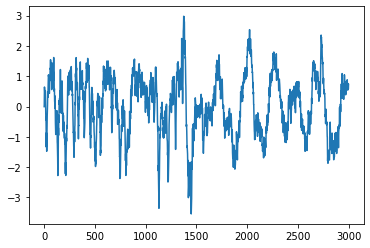

In [80]:
plt.plot(m[0]["negative_windows"][0][0])

In [93]:
batch_size = 128

def train_one_ssl(model, train_data, optimizer, epoch):
  model.train()
  
  train_losses = []
  for i in range(10):
    minibatch = get_minibatch(train_data, batch_size, n_negatives, n_context_windows, n_predict_windows, overlap, predict_delay)
    loss = model.forward(minibatch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
  return train_losses

def eval_loss_ssl(model, test_data):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for i in range(2):
      minibatch = get_minibatch(test_data, batch_size, n_negatives, n_context_windows, n_predict_windows, overlap, predict_delay)
      loss = model.forward(minibatch)
      total_loss += loss * batch_size
    avg_loss = total_loss / (2*batch_size)

  return avg_loss.item()

def train_epochs_ssl(model, train_data, test_data, train_args):
  epochs, lr = train_args['epochs'], train_args['lr']
  optimizer = optim.Adam(model.parameters(), lr=lr)

  train_losses = []
  test_losses = [eval_loss_ssl(model, test_data)]
  for epoch in range(epochs):
    model.train()
    train_losses.extend(train_one_ssl(model, train_data, optimizer, epoch))
    test_loss = eval_loss_ssl(model, test_data)
    test_losses.append(test_loss)
    print(f'Epoch {epoch}, Test loss {test_loss:.4f}')
  return train_losses, test_losses

In [94]:
class CPC_EEG(nn.Module):
  def __init__(self, C, T, n_context, n_predict, n_negatives, embedding_dim=100, k=50, m=13, dropout_prob=0.5, n_spatial_filters=8):
    super().__init__()
    self.n_context = n_context
    self.n_predict = n_predict
    self.n_negatives = n_negatives
    self.C = C
    self.T = T
    self.feature_extractor = EEG_FeatureExtractor(C, T, k, m, dropout_prob, embedding_dim, n_spatial_filters)
    self.cross_entropy = nn.CrossEntropyLoss()

  def forward(self, minibatch):
    """
    for each sample:
      encode context windows, prediction windows, negative windows
      aggregate context windows
      compute distances between (1) aggregated context windows and prediction windows encoding
                                (2) aggregated context windows and negative windows encoding
      do softmax with distances
      1 prediction distance and n_neg negative distance
      [prediction, neg1 distance, neg2 distance, , , ]
      
    """
    total_loss = 0
    for recording_dict in minibatch:
      recording_tensor = self.dict_to_tensor(recording_dict)
      embeddings = self.feature_extractor(recording_tensor)
      aggregated_context = self.aggregate_context_embeddings(embeddings[:self.n_context])
      distances = self.compute_distances(aggregated_context, embeddings[self.n_context:])
      loss = self.cross_entropy(distances, torch.zeros(len(distances)).cuda().long())
      total_loss += loss
    return total_loss/len(minibatch)
  
  def compute_distances(self, aggregated_context, comparison_embeddings):
    """
    Returns (n_predict, n_negatives+1) matrix
    """
    distances_vect = torch.matmul(comparison_embeddings, aggregated_context)
    distances = torch.cat((distances_vect[:self.n_predict].unsqueeze(dim=1),
                 distances_vect[self.n_predict:].reshape(self.n_predict, self.n_negatives)), dim=1)
    return distances
  
  def aggregate_context_embeddings(self, context_embeddings):
    return context_embeddings.mean(dim=0)
  
  def dict_to_tensor(self, minibatch_dict):
    tensor = np.zeros((self.n_context + self.n_predict + self.n_predict*self.n_negatives, 1, self.C, self.T))
    tensor[0:self.n_context] = np.array(minibatch_dict["context_windows"]).reshape(-1,1,self.C,self.T)
    tensor[self.n_context:self.n_context+self.n_predict] = np.array(minibatch_dict["predict_windows"]).reshape(-1,1,self.C,self.T)
    tensor[self.n_context+self.n_predict:] = np.array(minibatch_dict["negative_windows"]).reshape(-1,1,self.C,self.T)
    
    return torch.from_numpy(tensor).cuda().contiguous().float()

In [96]:
# def train_ssl(train_data, test_data, model):
C = 2 # num channels
T = 3000 # window length
model = CPC_EEG(C, T, n_context_windows, n_predict_windows, n_negatives).cuda()

train_losses, test_losses = train_epochs_ssl(model, train_data, test_data,
                                       dict(epochs=100, lr=1e-3))

#   return train_losses, test_losses, model

Epoch 0, Test loss 1.5539
Epoch 1, Test loss 1.4211
Epoch 2, Test loss 1.3722
Epoch 3, Test loss 1.3485
Epoch 4, Test loss 1.3103
Epoch 5, Test loss 1.3221
Epoch 6, Test loss 1.2983
Epoch 7, Test loss 1.2970
Epoch 8, Test loss 1.2950
Epoch 9, Test loss 1.2982
Epoch 10, Test loss 1.2422
Epoch 11, Test loss 1.2890
Epoch 12, Test loss 1.3016
Epoch 13, Test loss 1.3134
Epoch 14, Test loss 1.2675
Epoch 15, Test loss 1.2549
Epoch 16, Test loss 1.2335
Epoch 17, Test loss 1.2287
Epoch 18, Test loss 1.1724
Epoch 19, Test loss 1.1721
Epoch 20, Test loss 1.1556
Epoch 21, Test loss 1.1916
Epoch 22, Test loss 1.1919
Epoch 23, Test loss 1.1951
Epoch 24, Test loss 1.1520
Epoch 25, Test loss 1.1387
Epoch 26, Test loss 1.1862
Epoch 27, Test loss 1.1331
Epoch 28, Test loss 1.1720
Epoch 29, Test loss 1.1684
Epoch 30, Test loss 1.0506
Epoch 31, Test loss 1.1432
Epoch 32, Test loss 1.0980
Epoch 33, Test loss 1.1747
Epoch 34, Test loss 1.0845
Epoch 35, Test loss 1.0600
Epoch 36, Test loss 1.0834
Epoch 37, T

In [97]:
train_losses2, test_losses2 = train_epochs_ssl(model, train_data, test_data,
                                       dict(epochs=100, lr=1e-3))

Epoch 0, Test loss 1.0451
Epoch 1, Test loss 1.0218
Epoch 2, Test loss 1.0043
Epoch 3, Test loss 1.0532
Epoch 4, Test loss 1.0250
Epoch 5, Test loss 1.1007
Epoch 6, Test loss 0.9988
Epoch 7, Test loss 0.9895
Epoch 8, Test loss 1.0892
Epoch 9, Test loss 0.9869
Epoch 10, Test loss 0.9443
Epoch 11, Test loss 1.0045
Epoch 12, Test loss 0.9861
Epoch 13, Test loss 0.9753
Epoch 14, Test loss 1.0174
Epoch 15, Test loss 1.0403
Epoch 16, Test loss 0.9909
Epoch 17, Test loss 0.9772
Epoch 18, Test loss 1.0530
Epoch 19, Test loss 0.9656
Epoch 20, Test loss 1.0752
Epoch 21, Test loss 1.0088
Epoch 22, Test loss 0.9998
Epoch 23, Test loss 0.9563
Epoch 24, Test loss 0.9721
Epoch 25, Test loss 1.0728
Epoch 26, Test loss 0.9239
Epoch 27, Test loss 0.9730
Epoch 28, Test loss 0.9583
Epoch 29, Test loss 1.0023
Epoch 30, Test loss 1.0941
Epoch 31, Test loss 0.9359
Epoch 32, Test loss 0.9431
Epoch 33, Test loss 0.9439
Epoch 34, Test loss 0.9736
Epoch 35, Test loss 1.0053
Epoch 36, Test loss 0.9645
Epoch 37, T

In [100]:
train_losses3, test_losses3 = train_epochs_ssl(model, train_data, test_data,
                                       dict(epochs=100, lr=1e-3))

Epoch 0, Test loss 1.0111
Epoch 1, Test loss 0.9454
Epoch 2, Test loss 1.0188
Epoch 3, Test loss 0.9645
Epoch 4, Test loss 0.9688
Epoch 5, Test loss 0.9021
Epoch 6, Test loss 0.9973
Epoch 7, Test loss 0.9498
Epoch 8, Test loss 1.0069
Epoch 9, Test loss 0.8815
Epoch 10, Test loss 0.9796
Epoch 11, Test loss 0.8434
Epoch 12, Test loss 0.9611
Epoch 13, Test loss 0.9654
Epoch 14, Test loss 0.8828
Epoch 15, Test loss 1.0686
Epoch 16, Test loss 0.9316
Epoch 17, Test loss 0.9465
Epoch 18, Test loss 0.9328
Epoch 19, Test loss 0.8993
Epoch 20, Test loss 0.9321
Epoch 21, Test loss 0.8672
Epoch 22, Test loss 0.9673
Epoch 23, Test loss 0.9512
Epoch 24, Test loss 0.8831
Epoch 25, Test loss 0.9372
Epoch 26, Test loss 0.9848
Epoch 27, Test loss 1.0084
Epoch 28, Test loss 0.9549
Epoch 29, Test loss 0.9353
Epoch 30, Test loss 0.9940
Epoch 31, Test loss 0.9281
Epoch 32, Test loss 0.9260
Epoch 33, Test loss 0.9575
Epoch 34, Test loss 0.8774
Epoch 35, Test loss 0.8777
Epoch 36, Test loss 0.9016
Epoch 37, T

In [101]:
train_losses4, test_losses4 = train_epochs_ssl(model, train_data, test_data,
                                       dict(epochs=100, lr=1e-3))

Epoch 0, Test loss 0.9229
Epoch 1, Test loss 0.8735
Epoch 2, Test loss 1.0025
Epoch 3, Test loss 0.8785
Epoch 4, Test loss 1.0112
Epoch 5, Test loss 0.8711
Epoch 6, Test loss 0.9217
Epoch 7, Test loss 0.8711
Epoch 8, Test loss 0.9799
Epoch 9, Test loss 0.8482
Epoch 10, Test loss 0.8959
Epoch 11, Test loss 0.9526
Epoch 12, Test loss 0.9962
Epoch 13, Test loss 0.9109
Epoch 14, Test loss 0.9240
Epoch 15, Test loss 0.9302
Epoch 16, Test loss 0.9124
Epoch 17, Test loss 0.9606
Epoch 18, Test loss 1.0549
Epoch 19, Test loss 0.8558
Epoch 20, Test loss 0.9101
Epoch 21, Test loss 0.9254
Epoch 22, Test loss 0.9073
Epoch 23, Test loss 0.8735
Epoch 24, Test loss 0.9180
Epoch 25, Test loss 0.8990
Epoch 26, Test loss 0.9236
Epoch 27, Test loss 0.9412
Epoch 28, Test loss 0.9270
Epoch 29, Test loss 0.9190
Epoch 30, Test loss 0.8865
Epoch 31, Test loss 0.9242
Epoch 32, Test loss 0.8395
Epoch 33, Test loss 0.8733
Epoch 34, Test loss 0.9152
Epoch 35, Test loss 1.0448
Epoch 36, Test loss 0.9222
Epoch 37, T

In [102]:
train_losses5, test_losses5 = train_epochs_ssl(model, train_data, test_data,
                                       dict(epochs=100, lr=5e-4))

Epoch 0, Test loss 0.8770
Epoch 1, Test loss 0.8133
Epoch 2, Test loss 0.9001
Epoch 3, Test loss 0.8899
Epoch 4, Test loss 0.8898
Epoch 5, Test loss 0.8984
Epoch 6, Test loss 0.9111
Epoch 7, Test loss 0.8456
Epoch 8, Test loss 0.9540
Epoch 9, Test loss 0.9364
Epoch 10, Test loss 0.8976
Epoch 11, Test loss 0.9443
Epoch 12, Test loss 0.9019
Epoch 13, Test loss 0.9336
Epoch 14, Test loss 0.9007
Epoch 15, Test loss 0.9223
Epoch 16, Test loss 0.8445
Epoch 17, Test loss 0.8830
Epoch 18, Test loss 0.8982
Epoch 19, Test loss 0.8027
Epoch 20, Test loss 0.8919
Epoch 21, Test loss 0.9132
Epoch 22, Test loss 0.8371
Epoch 23, Test loss 0.8919
Epoch 24, Test loss 0.9551
Epoch 25, Test loss 0.8611
Epoch 26, Test loss 0.9340
Epoch 27, Test loss 0.9119
Epoch 28, Test loss 0.9297
Epoch 29, Test loss 0.9084
Epoch 30, Test loss 0.8957
Epoch 31, Test loss 0.9222
Epoch 32, Test loss 0.8697
Epoch 33, Test loss 0.8626
Epoch 34, Test loss 0.9264
Epoch 35, Test loss 0.9006
Epoch 36, Test loss 0.9656
Epoch 37, T

In [104]:
torch.save(model.state_dict(), 'model.h')

## Linear Layer

In [147]:
class SSL_Linear(nn.Module):
  def __init__(self, model):
    super().__init__()
    self.model = model
    self.model.requires_grad = False
    self.linear = nn.Linear(100, 5)
    self.loss_fn = nn.CrossEntropyLoss()

  def forward(self, x):
    with torch.no_grad():
      features = self.model.feature_extractor(x)
    out = self.linear(features)
    return out

  def loss(self, x, y_true):
    out = self(x)
    return self.loss_fn(out, y_true)

In [148]:
def train_linear_ssl(epochs_train, epochs_test):
  X_train = normalize(epochs_train.get_data())
  y_train = epochs_train.events[:, 2] - 1 # start at 0

  X_test = normalize(epochs_test.get_data())
  y_test = epochs_test.events[:, 2] - 1
  
  linear_model = SSL_Linear(model).cuda()

  train_dataset = data.TensorDataset(torch.tensor(X_train).unsqueeze(1), torch.tensor(y_train))
  train_loader = data.DataLoader(train_dataset, batch_size=256, shuffle=True)

  test_dataset = data.TensorDataset(torch.tensor(X_test).unsqueeze(1), torch.tensor(y_test))
  test_loader = data.DataLoader(test_dataset, batch_size=256, shuffle=True)

  train_losses, test_losses = train_epochs(linear_model, train_loader, test_loader, 
                                         dict(epochs=5, lr=1e-3))

  return train_losses, test_losses, linear_model

In [149]:
train_losses_linear, test_losses_linear, linear_model = train_linear_ssl(epochs_train, epochs_test)

Epoch 0, Test loss 0.5934
Epoch 1, Test loss 0.4655
Epoch 2, Test loss 0.4147
Epoch 3, Test loss 0.3893
Epoch 4, Test loss 0.3760


In [150]:
X_test = normalize(epochs_test.get_data())
y_test = epochs_test.events[:, 2] - 1

test_dataset = data.TensorDataset(torch.tensor(X_test).unsqueeze(1), torch.tensor(y_test))
test_loader = data.DataLoader(test_dataset, batch_size=256, shuffle=True)

In [151]:
import IPython
e = IPython.embed

In [152]:
def accuracy_score(linear_model, test_loader):
  correct = 0
  total = 0
  linear_model.eval()
  softmax = nn.Softmax()
  with torch.no_grad():
    for pair in test_loader:
      x, y = pair[0], pair[1]
      x = x.cuda().float().contiguous()
      y = y.cuda().long().contiguous()
      out = linear_model(x)
      _, predicted = torch.max(softmax(out.data), 1)
      total += y.size(0)
      correct += (predicted == y).sum().item()

  print(f'Accuracy of the network on the {len(test_loader.dataset)} test images: {round(100 * correct / total)}%')

In [153]:
accuracy_score(linear_model, test_loader)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Accuracy of the network on the 27295 test images: 86%


## Others

In [ ]:
raw_train.plot(duration=60, scalings='auto')

In [ ]:
raw_train.plot_psd()

In [ ]:
A = raw_train.pick_types(eeg=True)
a = A[:][0]